In [1]:
import pandas as pd
import pandas_ta as ta
import os
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

Run `orderbook_delta_generator.py`, this full scipt will take around 5 hours as the data is not available from any historical sources and needs to be collected live.
You can run the analyzer while `orderbook_delta_generator.py` is running as the data is saved at every point. The data is stored in a csv with the following columns:


| Name | Symbol | Formula |
| --- | --- | --- |
| `spot_bid_price` | $P_{\text{bid, spot}}$ | --- |
| `spot_ask_price` | $P_{\text{ask, spot}}$ | --- |
| `perp_bid_price` | $P_{\text{bid, perp}}$ | --- |
| `perp_ask_price` | $P_{\text{ask, perp}}$ | --- |
| `spot_delta` | $\Delta_{\text{spot}}$ | $$ V_{\text{bid, spot}}(d) - V_{\text{ask, spot}}(d) $$ |
| `perp_delta` | $\Delta_{\text{perp}}$ | $$ V_{\text{bid, perp}}(d) - V_{\text{ask, perp}}(d) $$ | 
| `delta_div` | $\Delta_{\text{div}}$ | $$ \Delta_{\text{spot}}(d) - \Delta_{\text{perp}}(d) $$ |

where, 
$$d = \text{depth of the orderbook}$$
$$V(d) = \text{volume of order on the books at depth } d$$

The idea behind this is the concept of _mean reversion_. 
We look for deviations in the perp orderbook $\Delta_{\text{perp}}$ at $d=0$ that are larger than 3 standard deviations 
from a 21 period rolling bollinger band. These deviations could be caused by over-excited and over-leveraged market participants.

We counter trade those deviations, with the positions such that:

| Trigger | Position |
| --- | --- |
| $$\Delta_{\text{perp}} > BB(21)_{\text{upper}}$$ | short |
| $$\Delta_{\text{perp}} < BB(21)_{\text{lower}}$$ | long |

We are testing this with `BTC-PERP` on FTX, which has good liquidity and small spreads. In principle, the scheme could be modified for lower liquidity pairs too, perhaps by adjusting the bollinger band width and length for generating triggers.

In [2]:
ORDERBOOK_PATHS = [os.path.join("..", "data", "19-03-2022_13-31_delta.csv"), 
                   os.path.join("..", "data", "19-03-2022_17-30_delta.csv")]

In [ ]:
def get_profitability(df_orders: pd.DataFrame) -> list:
    """ 
        Extract profitability of trades based on positions taken. 
        - For long entries we enter with the ask price and exit with the bid price
        - For short entries we enter with the bid price and exit with the ask price
    """
    entry = None
    position = None

    profits = []
    profit = 0
    for row in df_orders.itertuples(index=True):
        if entry:
            if position == "long":
                exit = row.bid_price
            elif position == "short":
                exit = row.ask_price

        if position == "long":
            profit += exit - entry
        elif position == "short":
            profit += entry - exit

        if row.position == "long":
            entry = row.ask_price
            position = "long"
        elif row.position == "short":
            entry = row.bid_price
            position = "short"

        profits.append(profit)
        # print(row.Index, row.price, row.position, position, profit)
    return profits

def trigger_conditions(trigger_set: int) -> pd.Series:
    """ Define logical conditions for long/short positions """
    c1 = df.perp_delta < perp_delta_bbands.iloc[:, 0]
    c2 = df.perp_delta > perp_delta_bbands.iloc[:, 2]
    
    c3 = df.perp_bid_price > perp_bid_price_bbands.iloc[:, 0]
    c4 = df.perp_bid_price < perp_bid_price_bbands.iloc[:, 2]
    
    if trigger_set == 0:
        return c1
    elif trigger_set == 1:
        return c2
    elif trigger_set == 2:
        return c1 & (c3 | c4)
    elif trigger_set == 3:
        return c2 & (c3 | c4)

In [ ]:
df = pd.DataFrame()
for orderbook_paths in ORDERBOOK_PATHS:
    _df = pd.read_csv(orderbook_paths, index_col="time").drop("Unnamed: 0", axis=1)
    _df.drop_duplicates(inplace=True)
    df = pd.concat([df, _df], ignore_index=False, sort=True)

In [ ]:
df = pd.read_csv(ORDERBOOK_PATHS[1], index_col="time").drop("Unnamed: 0", axis=1)

In [ ]:
df

In [ ]:
BBAND1_LEN = 20
BBAND2_LEN = 10
STD = 3

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Plot spot and perp deltas
fig.append_trace(go.Scatter(x=df.index, y=df.spot_delta, mode="markers", name="Spot Delta", 
                            marker=dict(color="#ff7f0e", size=3, symbol='cross-open')), row=1, col=1)
fig.append_trace(go.Scatter(x=df.index, y=df.perp_delta, mode="markers", name="Perp Delta", 
                            marker=dict(color="#9467bd", size=3, symbol='circle-open')), row=1, col=1)


# Plot perp delta bollinger bands
perp_delta_bbands = ta.bbands(df["perp_delta"], length=BBAND1_LEN, std=STD)
fig.append_trace(go.Scatter(x=df.index, y=perp_delta_bbands.iloc[:, 0], mode="lines", name="Lower Bollinger Band", 
                            line_color="#d62728", line_width=0.5), row=1, col=1)
fig.append_trace(go.Scatter(x=df.index, y=perp_delta_bbands.iloc[:, 2], mode="lines", name="Upper Bollinger Band", 
                            line_color="#2ca02c", line_width=0.5), row=1, col=1)

# Plot spot and perp bid prices
fig.append_trace(go.Scatter(x=df.index, y=df.spot_bid_price, mode="markers", name="Spot Bid Price", 
                            marker=dict(color="#ff7f0e", size=3, symbol='cross-open')), row=2, col=1)
#fig.append_trace(go.Scatter(x=df.index, y=df.spot_ask_price, mode="markers", name="Spot Ask Price", 
#                            marker=dict(color="red", size=4, symbol='cross-open')), row=2, col=1)
fig.append_trace(go.Scatter(x=df.index, y=df.perp_bid_price, mode="markers", name="Perp Bid Price",
                            marker=dict(color="#9467bd", size=3, symbol='circle-open')), row=2, col=1)
#fig.append_trace(go.Scatter(x=df.index, y=df.perp_ask_price, mode="markers", name="Perp Ask Price",
#                            marker=dict(color="red", size=4, symbol='circle-open')), row=2, col=1)

# Plot perp bid price bollinger bands
perp_bid_price_bbands = ta.bbands(df["perp_bid_price"], length=BBAND2_LEN, std=STD)
fig.append_trace(go.Scatter(x=df.index, y=perp_bid_price_bbands.iloc[:, 0], mode="lines", name="Lower Bollinger Band", 
                            line_color="#d62728", line_width=0.5), row=2, col=1)
fig.append_trace(go.Scatter(x=df.index, y=perp_bid_price_bbands.iloc[:, 2], mode="lines", name="Upper Bollinger Band", 
                            line_color="#2ca02c", line_width=0.5), row=2, col=1)

# Get all entries and exits in a DataFrame, and plot them
df_orders = pd.DataFrame(columns=["time", "bid_price", "ask_price", "position"])
idx = 0
for index in df.index[trigger_conditions(trigger_set=0)]:
    fig.add_vline(x=index, line_dash="dot", row=2, col=1, line=dict(color="#d62728"))
    df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "short"]
    idx += 1
for index in df.index[trigger_conditions(trigger_set=1)]:
    fig.add_vline(x=index, line_dash="dash", row=2, col=1, line=dict(color="#2ca02c"))
    df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "long"]
    idx += 1

# Compute profitability and plot result
df_orders = df_orders.set_index("time").sort_index()
fig.append_trace(go.Scatter(x=df_orders.index, y=get_profitability(df_orders), mode="markers+lines", name="Profit", 
                            marker=dict(color="#1f77b4", size=4, symbol='circle-open')), row=3, col=1)

fig.update_yaxes(title_text="Delta", row=1, col=1)
fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_yaxes(title_text="Profit", row=3, col=1)

fig.update_layout(height=700, width=1200)
fig.show()

# fig.write_image(os.path.join("..", "images", "orderbook_delta_analyzer.png"))
# fig.write_html(os.path.join("..", "images", "orderbook_delta_analyzer.html"))

# Simple Optimizer

Optimize to max profit

In [ ]:
import numpy as np
import itertools
from tqdm import tqdm

In [ ]:
bbands_lens = [10, 15, 20, 21, 25, 30]
stds = [2, 2.5, 3, 3.5, 4]

profit = np.zeros(len(bbands_lens) * len(bbands_lens) * len(stds))

iterator = tqdm(itertools.product(bbands_lens, bbands_lens, stds))

for _idx, (bbands_len1, bbands_len2, std) in enumerate(iterator):
    perp_delta_bbands = ta.bbands(df["perp_delta"], length=bbands_len1, std=std)
    perp_bid_price_bbands = ta.bbands(df["perp_bid_price"], length=bbands_len2, std=std)

    df_orders = pd.DataFrame(columns=["time", "bid_price", "ask_price", "position"])
    idx = 0
    for index in df.index[trigger_conditions(trigger_set=0)]:
        df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "short"]
        idx += 1
    for index in df.index[trigger_conditions(trigger_set=1)]:
        df_orders.loc[idx] = [index, df.perp_bid_price[index], df.perp_ask_price[index], "long"]
        idx += 1

    # Compute profitability and plot result
    df_orders = df_orders.set_index("time").sort_index()

    profits = get_profitability(df_orders)
    if len(profits) == 0:
        profit[_idx] = 0
    else:
        profit[_idx] = profits[-1]

In [ ]:
for _idx, (bbands_len1, bbands_len2, std) in enumerate(itertools.product(bbands_lens, bbands_lens, stds)):
    if _idx == np.argmax(profit):
        print(f"Max profit of {profit[_idx]} at BBAND_LEN=({bbands_len1}, {bbands_len2}), STD={std}")
        break

# Position sizing with Kelly criterion

Position sizing using Kelly criterion

$$ f* = p + \frac{p - 1}{b} $$

where,  
$f*$ is the fraction of the  size of the position to take  
$p$ is the probability of a win  
$b$ is the fraction gained on winning  

We restrict the space to set of values 

$ b \in [1.05, 2] $  
$ p \in [0.1, 1] $

In [ ]:
def kelly_size(p: np.ndarray, b: float) -> np.ndarray:
    return p + (p - 1) / b

In [ ]:
probability = np.linspace(0.1, 1, 10)
fraction_gained = np.arange(1.05, 2, 0.15)

fig2 = go.Figure()
    
for b in fraction_gained:
    fraction = kelly_size(probability, b)
    
    fig2.add_trace(
        go.Scatter(
            x=p, 
            y=fraction, 
            mode="markers+lines", 
            name=f"b={b:.2f}"
        )
    )

# fig2.update_xaxes(type="log")

fig2.update_layout(
    xaxis_title="Probability p",
    yaxis_title="Kelly size f*",
)

fig2.show()

# Time series analysis

## Looking for
1. Seasonal patterns
2. Cyclical patterns


## Some concerns:
1. Correlated erros
2. Cross-validation
3. Lookahead
4. Sationarity

In [3]:
ORDERBOOK_PATHS = [os.path.join("..", "data", "19-03-2022_13-31_delta.csv"), 
                   os.path.join("..", "data", "19-03-2022_17-30_delta.csv")]

In [4]:
df = pd.read_csv(ORDERBOOK_PATHS[1], index_col="time").drop("Unnamed: 0", axis=1)

In [ ]:
fig = go.Figure()

fig.add_scatter(
    x=df.index,
    y=df["perp_delta"],
    name="Perp delta",
    mode="markers+lines",
    marker=dict(size=4)
)

fig.add_scatter(
    x=df.index,
    y=df["spot_delta"],
    name="Spot delta",
    mode="markers+lines",
    marker=dict(size=4)
)

# ARIMA(p, d, q) modeling

$$ \left(1 - \sum_{i=1}^{p} \phi_iL^i \right) (1 - L)^d X_t = \left(1 + \sum_{i=1}^{q}\theta_iL^i \right)\epsilon_t $$

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [6]:
df = df.reset_index(drop=True)

In [7]:
result = adfuller(df.perp_delta.dropna())
print(f"p-value = {result[1]:.2f}")

p-value = 0.00


$d = 1$

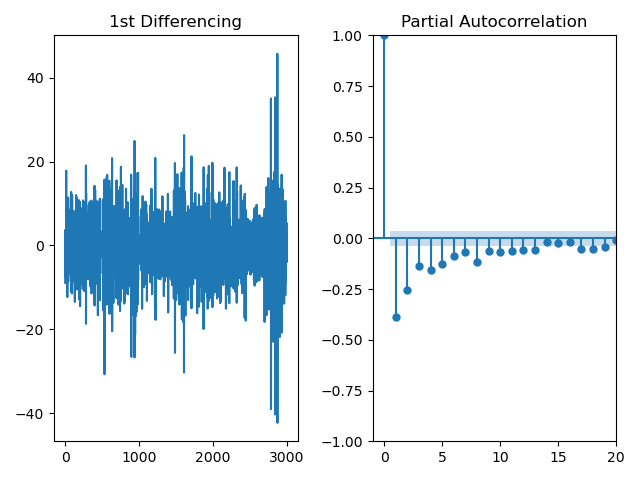

In [8]:
%matplotlib widget
# PACF plot of 1st differenced series
fig, ax = plt.subplots(1, 2)

ax[0].plot(df.perp_delta.diff())
ax[0].set_title('1st Differencing')

plot_pacf(df.perp_delta.diff().dropna(), ax=ax[1], method="ywm")
ax[1].set_xlim(-1, 20)

fig.tight_layout()
plt.show()

This gives us $p=1$

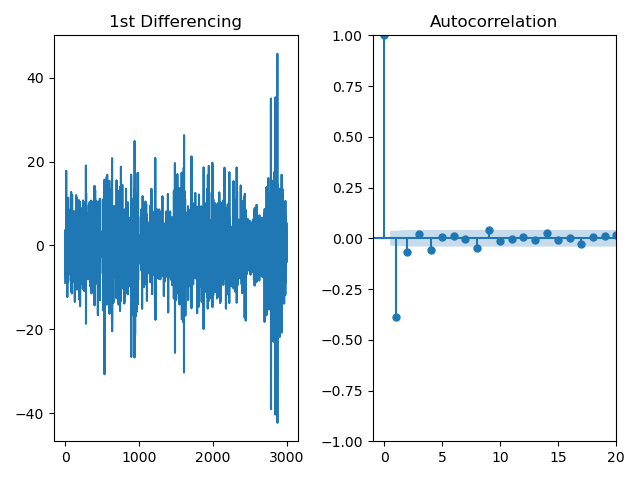

In [9]:
%matplotlib widget

fig, ax = plt.subplots(1, 2)
ax[0].plot(df.perp_delta.diff())
ax[0].set_title('1st Differencing')

plot_acf(df.perp_delta.diff().dropna(), ax=ax[1])
ax[1].set_xlim(-1, 20)

fig.tight_layout()

Let's set $q = 0$

In [10]:
model = sm.tsa.statespace.SARIMAX(df.perp_delta, order=(1, 1, 0))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             perp_delta   No. Observations:                 3000
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -9369.848
Date:                Sat, 23 Apr 2022   AIC                          18743.697
Time:                        03:18:55   BIC                          18755.709
Sample:                             0   HQIC                         18748.017
                               - 3000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3864      0.010    -38.959      0.000      -0.406      -0.367
sigma2        30.2868      0.432     70.038      0.000      29.439      31.134
Ljung-Box (L1) (Q):                  28.86   Jarque-

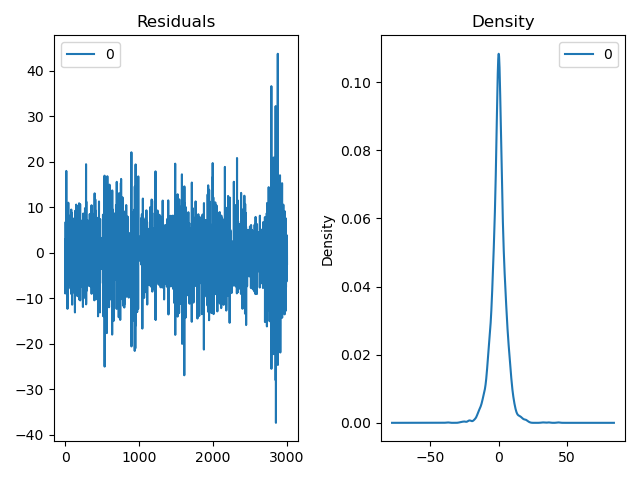

In [11]:
%matplotlib widget

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# residuals.reset_index(inplace=True, drop=True)

fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

fig.tight_layout()

In [12]:
predict = model_fit.get_prediction()
predict_ci = predict.conf_int()

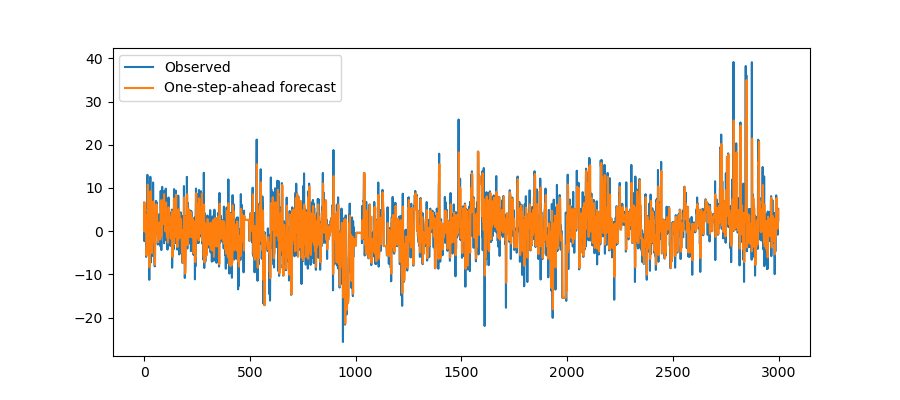

In [13]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(9, 4))

df.perp_delta.plot(ax=ax, style='-', label='Observed')
predict.predicted_mean.plot(ax=ax, style='-', label='One-step-ahead forecast')
# ax.fill_between(predict_ci.index, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], color='r', alpha=0.1)
ax.legend()

# Unobserved Components Model

In [14]:
model = {
    "level": "smooth trend",
    "cycle": False,
    "seasonal": False
}

In [15]:
uo_mod = sm.tsa.UnobservedComponents(df.perp_delta, **model)
uo_res = uo_mod.fit()
print(uo_res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32269D+00    |proj g|=  6.99017D-02

At iterate    5    f=  3.11386D+00    |proj g|=  5.54334D-02

At iterate   10    f=  3.11148D+00    |proj g|=  1.28366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   4.200D-07   3.111D+00
  F =   3.1114844963483113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                        Unobserved Components Results                 

 This problem is unconstrained.


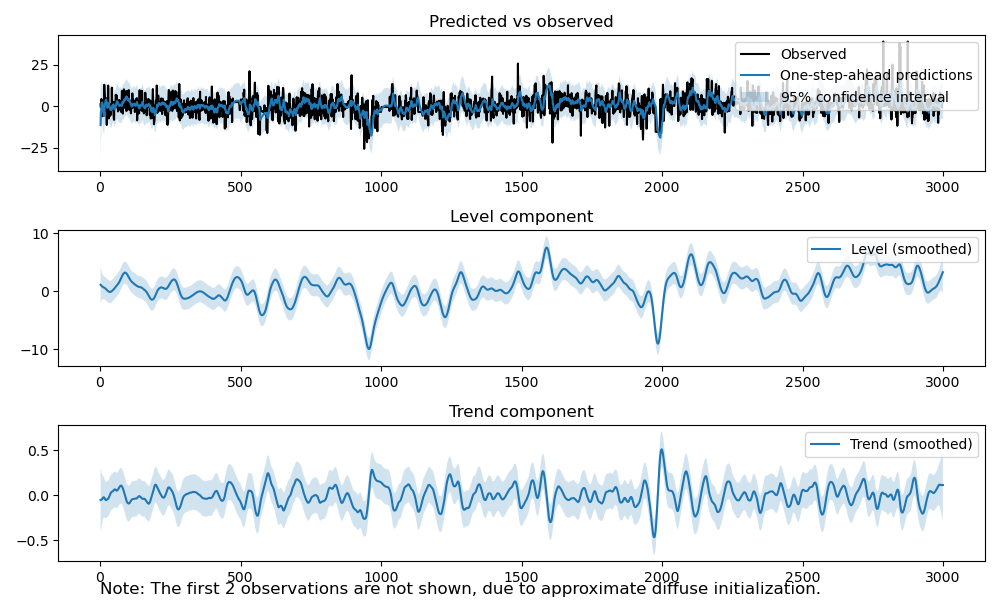

In [16]:
%matplotlib widget
fig = uo_res.plot_components(figsize=(10, 6))
fig.tight_layout()

In [17]:
num_steps = 20
predict_res = uo_res.get_prediction(dynamic=df.shape[0] - num_steps)

predict = predict_res.predicted_mean
predict_ci = predict_res.conf_int()

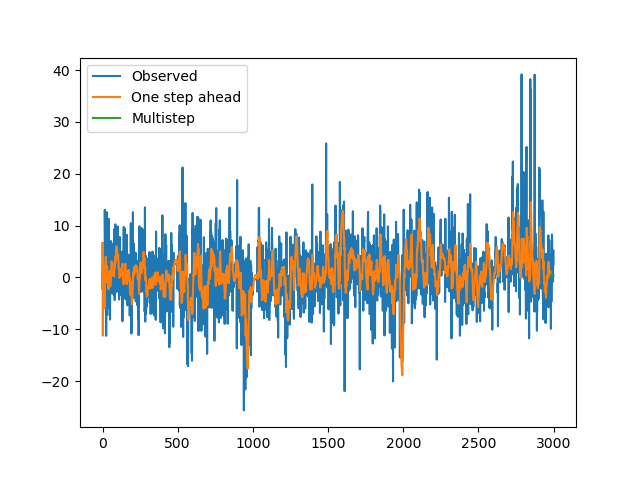

In [18]:
fig, ax = plt.subplots()

ax.plot(df.perp_delta, label="Observed")
ax.plot(df.index[:-num_steps], predict[:-num_steps], label="One step ahead")

ax.plot(df.index[-num_steps:], predict[-num_steps:], label="Multistep")
# ax.fill_between(predict_ci.index, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], alpha=0.1)

ax.legend()

# ML based time series analysis

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
perp = df[['perp_delta']]
perp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   perp_delta  3000 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [21]:
scaler = MinMaxScaler(feature_range=(-1, 1))
perp["perp_delta"] = scaler.fit_transform(perp["perp_delta"].values.reshape(-1, 1))

/var/folders/lv/5l60cz4j7mg_xthlrzqvyt8m0000gn/T/ipykernel_277/1835425707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perp["perp_delta"] = scaler.fit_transform(perp["perp_delta"].values.reshape(-1, 1))


In [22]:
def split_data(perp_delta, lookback):
    data_raw = perp_delta.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(perp, lookback)

In [23]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2384, 19, 1)
y_train.shape =  (2384, 1)
x_test.shape =  (596, 19, 1)
y_test.shape =  (596, 1)


In [24]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [25]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [27]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.03442904353141785
Epoch  1 MSE:  0.03782586380839348
Epoch  2 MSE:  0.031086700037121773
Epoch  3 MSE:  0.029605727642774582
Epoch  4 MSE:  0.030633872374892235
Epoch  5 MSE:  0.03112196736037731
Epoch  6 MSE:  0.030674928799271584
Epoch  7 MSE:  0.029931996017694473
Epoch  8 MSE:  0.02943999692797661
Epoch  9 MSE:  0.029402533546090126
Epoch  10 MSE:  0.029665863141417503
Epoch  11 MSE:  0.029845749959349632
Epoch  12 MSE:  0.02974918857216835
Epoch  13 MSE:  0.02947862073779106
Epoch  14 MSE:  0.02921675704419613
Epoch  15 MSE:  0.029067058116197586
Epoch  16 MSE:  0.029030025005340576
Epoch  17 MSE:  0.02904527075588703
Epoch  18 MSE:  0.029038570821285248
Epoch  19 MSE:  0.02895534783601761
Epoch  20 MSE:  0.028778525069355965
Epoch  21 MSE:  0.02852996066212654
Epoch  22 MSE:  0.028257450088858604
Epoch  23 MSE:  0.028009699657559395
Epoch  24 MSE:  0.027792226523160934
Epoch  25 MSE:  0.02750394120812416
Epoch  26 MSE:  0.026964638382196426
Epoch  27 MSE:  0.0261

In [29]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

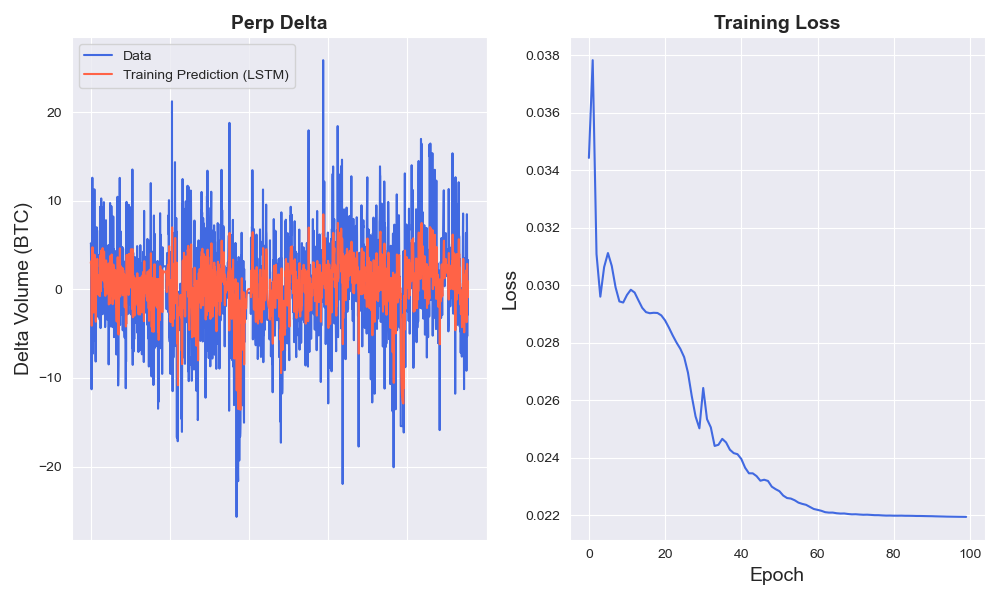

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")    

fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Perp Delta', size = 14, fontweight='bold')
ax.set_ylabel("Delta Volume (BTC)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')

fig.tight_layout()

In [36]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 4.80 RMSE
Test Score: 5.56 RMSE


In [37]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(perp)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(perp)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(perp)-1, :] = y_test_pred

original = scaler.inverse_transform(perp['perp_delta'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

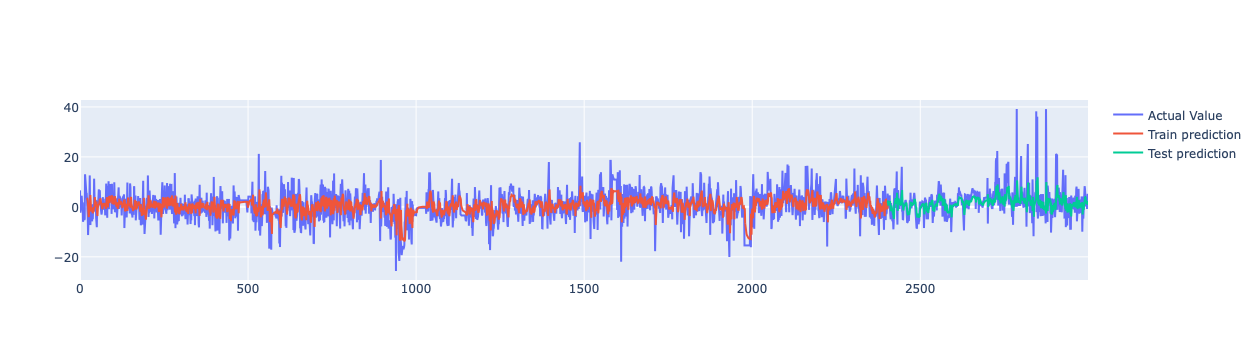

In [38]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()